# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 2 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand. 

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [3]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if y.shape[0] == 0:
        return 0
    return np.sum(np.abs(y - np.mean(y))) / y.shape[0]

In [4]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [5]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   
    Rl, Rr = y[X[:, j] <= t], y[X[:, j] > t]
    Q = Rl.shape[0] / X.shape[0] * H(Rl) + Rr.shape[0] / X.shape[0] * H(Rr)
    
    return Q

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [6]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node 
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [7]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y) 
        
        for j in range(X.shape[1]):
            for t in X[:, j]:
                q = Q(X, y, j, t)
                if q < best_cost:
                    best_cost = q
                    best_split_column = j
                    best_threshold = t
        
        if best_split_column is None:
            return None, None, None, None, None, None

        condition = X[:, best_split_column] <= best_threshold

        X_left, X_right = X[condition], X[~condition]
        y_left, y_right = y[condition], y[~condition]
        
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`, 
        `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        if self.is_terminal(node, y):
            node.is_terminal = True
            return
                
        best_split_column, best_threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)

        if best_split_column is None or best_threshold is None:
            node.is_terminal = True
            return

        node.column = best_split_column
        node.threshold = best_threshold

        # Left
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.prediction = np.mean(y_left)
        self.grow_tree(node.left, X_left, y_left)

        # Right
        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.prediction = np.mean(y_right)
        self.grow_tree(node.right, X_right, y_right)
        

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        
        # Initialize the tree (root node)
        self.tree_ = Node()                             
        self.tree_.depth = 1                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get 
            predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        if node.is_terminal:
            return node.prediction

        if x[node.column] <= node.threshold:
            return self.get_prediction(node.left, x)
        else:
            return self.get_prediction(node.right, x)
        
        return y_pred
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [8]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

C:\Users\60130060\Anaconda3\lib\site-packages\sklearn\utils\estimator_checks.py:3608: FutureWarning: As of scikit-learn 0.23, estimators should expose a n_features_in_ attribute, unless the 'no_validation' tag is True. This attribute should be equal to the number of features passed to the fit method. An error will be raised from version 1.0 (renaming of 0.25) when calling check_estimator(). See SLEP010: https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep010/proposal.html
  warnings.warn(
C:\Users\60130060\Anaconda3\lib\site-packages\sklearn\utils\estimator_checks.py:3652: FutureWarning: As of scikit-learn 0.23, estimators should have a 'requires_y' tag set to the appropriate value. The default value of the tag is False. An error will be raised from version 1.0 when calling check_estimator() if the tag isn't properly set.
  warnings.warn(warning_msg, FutureWarning)


In [81]:
# это ворнинг, все ок)

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of depth 1 and make the following plot:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model 

In [11]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

df = load_boston()
df

C:\Users\60130060\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing datase

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        ...,
        [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
         6.4800e+00],
        [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         7.8800e+00]]),
 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
        15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
        13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
        21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
        35.4, 24.7, 3

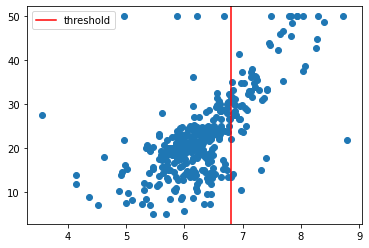

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['target'], test_size=0.25)

model = MyDecisionTreeRegressor(max_depth=2)
model.fit(X_train, y_train)


plt.scatter(X_train[:, model.tree_.column], y_train)
plt.axvline(x = model.tree_.threshold, color = 'red', label = 'threshold')
plt.legend()

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `MAE` on test dataset and hyperparameters of the best estimator. 

In [84]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth' : np.linspace(1, 100, 30, dtype=int), \
          'min_samples_leaf' : np.linspace(1, 100, 30, dtype=int)}
cv = GridSearchCV(MyDecisionTreeRegressor(), params, cv=5, verbose=4).fit(X_train, y_train)
cv.best_params_

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV 1/5] END ..max_depth=1, min_samples_leaf=1;, score=-0.004 total time=   0.0s
[CV 2/5] END ..max_depth=1, min_samples_leaf=1;, score=-0.001 total time=   0.0s
[CV 3/5] END ..max_depth=1, min_samples_leaf=1;, score=-0.000 total time=   0.0s
[CV 4/5] END ..max_depth=1, min_samples_leaf=1;, score=-0.001 total time=   0.0s
[CV 5/5] END ..max_depth=1, min_samples_leaf=1;, score=-0.004 total time=   0.0s
[CV 1/5] END ..max_depth=1, min_samples_leaf=4;, score=-0.004 total time=   0.0s
[CV 2/5] END ..max_depth=1, min_samples_leaf=4;, score=-0.001 total time=   0.0s
[CV 3/5] END ..max_depth=1, min_samples_leaf=4;, score=-0.000 total time=   0.0s
[CV 4/5] END ..max_depth=1, min_samples_leaf=4;, score=-0.001 total time=   0.0s
[CV 5/5] END ..max_depth=1, min_samples_leaf=4;, score=-0.004 total time=   0.0s
[CV 1/5] END ..max_depth=1, min_samples_leaf=7;, score=-0.004 total time=   0.0s
[CV 2/5] END ..max_depth=1, min_samples_leaf=

[CV 1/5] END ...max_depth=4, min_samples_leaf=1;, score=0.480 total time=   0.4s
[CV 2/5] END ...max_depth=4, min_samples_leaf=1;, score=0.681 total time=   0.3s
[CV 3/5] END ...max_depth=4, min_samples_leaf=1;, score=0.629 total time=   0.4s
[CV 4/5] END ...max_depth=4, min_samples_leaf=1;, score=0.664 total time=   0.4s
[CV 5/5] END ...max_depth=4, min_samples_leaf=1;, score=0.823 total time=   0.3s
[CV 1/5] END ...max_depth=4, min_samples_leaf=4;, score=0.480 total time=   0.4s
[CV 2/5] END ...max_depth=4, min_samples_leaf=4;, score=0.681 total time=   0.3s
[CV 3/5] END ...max_depth=4, min_samples_leaf=4;, score=0.629 total time=   0.4s
[CV 4/5] END ...max_depth=4, min_samples_leaf=4;, score=0.664 total time=   0.4s
[CV 5/5] END ...max_depth=4, min_samples_leaf=4;, score=0.823 total time=   0.3s
[CV 1/5] END ...max_depth=4, min_samples_leaf=7;, score=0.480 total time=   0.3s
[CV 2/5] END ...max_depth=4, min_samples_leaf=7;, score=0.681 total time=   0.4s
[CV 3/5] END ...max_depth=4,

[CV 3/5] END ..max_depth=4, min_samples_leaf=69;, score=0.629 total time=   0.4s
[CV 4/5] END ..max_depth=4, min_samples_leaf=69;, score=0.664 total time=   0.4s
[CV 5/5] END ..max_depth=4, min_samples_leaf=69;, score=0.823 total time=   0.3s
[CV 1/5] END ..max_depth=4, min_samples_leaf=72;, score=0.480 total time=   0.3s
[CV 2/5] END ..max_depth=4, min_samples_leaf=72;, score=0.681 total time=   0.3s
[CV 3/5] END ..max_depth=4, min_samples_leaf=72;, score=0.629 total time=   0.4s
[CV 4/5] END ..max_depth=4, min_samples_leaf=72;, score=0.664 total time=   0.4s
[CV 5/5] END ..max_depth=4, min_samples_leaf=72;, score=0.823 total time=   0.4s
[CV 1/5] END ..max_depth=4, min_samples_leaf=76;, score=0.480 total time=   0.3s
[CV 2/5] END ..max_depth=4, min_samples_leaf=76;, score=0.681 total time=   0.3s
[CV 3/5] END ..max_depth=4, min_samples_leaf=76;, score=0.629 total time=   0.4s
[CV 4/5] END ..max_depth=4, min_samples_leaf=76;, score=0.664 total time=   0.4s
[CV 5/5] END ..max_depth=4, 

[CV 5/5] END ..max_depth=7, min_samples_leaf=35;, score=0.872 total time=   0.9s
[CV 1/5] END ..max_depth=7, min_samples_leaf=38;, score=0.454 total time=   0.9s
[CV 2/5] END ..max_depth=7, min_samples_leaf=38;, score=0.744 total time=   1.0s
[CV 3/5] END ..max_depth=7, min_samples_leaf=38;, score=0.628 total time=   1.0s
[CV 4/5] END ..max_depth=7, min_samples_leaf=38;, score=0.751 total time=   0.9s
[CV 5/5] END ..max_depth=7, min_samples_leaf=38;, score=0.872 total time=   1.0s
[CV 1/5] END ..max_depth=7, min_samples_leaf=41;, score=0.454 total time=   1.0s
[CV 2/5] END ..max_depth=7, min_samples_leaf=41;, score=0.744 total time=   1.0s
[CV 3/5] END ..max_depth=7, min_samples_leaf=41;, score=0.628 total time=   0.9s
[CV 4/5] END ..max_depth=7, min_samples_leaf=41;, score=0.751 total time=   1.0s
[CV 5/5] END ..max_depth=7, min_samples_leaf=41;, score=0.872 total time=   1.0s
[CV 1/5] END ..max_depth=7, min_samples_leaf=45;, score=0.454 total time=   1.0s
[CV 2/5] END ..max_depth=7, 

[CV 2/5] END ..max_depth=11, min_samples_leaf=4;, score=0.753 total time=   2.3s
[CV 3/5] END ..max_depth=11, min_samples_leaf=4;, score=0.618 total time=   2.2s
[CV 4/5] END ..max_depth=11, min_samples_leaf=4;, score=0.705 total time=   2.1s
[CV 5/5] END ..max_depth=11, min_samples_leaf=4;, score=0.837 total time=   2.3s
[CV 1/5] END ..max_depth=11, min_samples_leaf=7;, score=0.491 total time=   3.5s
[CV 2/5] END ..max_depth=11, min_samples_leaf=7;, score=0.753 total time=   2.9s
[CV 3/5] END ..max_depth=11, min_samples_leaf=7;, score=0.618 total time=   1.9s
[CV 4/5] END ..max_depth=11, min_samples_leaf=7;, score=0.705 total time=   2.0s
[CV 5/5] END ..max_depth=11, min_samples_leaf=7;, score=0.837 total time=   1.9s
[CV 1/5] END .max_depth=11, min_samples_leaf=11;, score=0.491 total time=   1.8s
[CV 2/5] END .max_depth=11, min_samples_leaf=11;, score=0.753 total time=   2.0s
[CV 3/5] END .max_depth=11, min_samples_leaf=11;, score=0.618 total time=   2.0s
[CV 4/5] END .max_depth=11, 

[CV 4/5] END .max_depth=11, min_samples_leaf=72;, score=0.705 total time=   1.3s
[CV 5/5] END .max_depth=11, min_samples_leaf=72;, score=0.837 total time=   1.3s
[CV 1/5] END .max_depth=11, min_samples_leaf=76;, score=0.491 total time=   1.4s
[CV 2/5] END .max_depth=11, min_samples_leaf=76;, score=0.753 total time=   1.4s
[CV 3/5] END .max_depth=11, min_samples_leaf=76;, score=0.618 total time=   1.4s
[CV 4/5] END .max_depth=11, min_samples_leaf=76;, score=0.705 total time=   1.3s
[CV 5/5] END .max_depth=11, min_samples_leaf=76;, score=0.837 total time=   1.3s
[CV 1/5] END .max_depth=11, min_samples_leaf=79;, score=0.491 total time=   1.3s
[CV 2/5] END .max_depth=11, min_samples_leaf=79;, score=0.753 total time=   1.4s
[CV 3/5] END .max_depth=11, min_samples_leaf=79;, score=0.618 total time=   1.4s
[CV 4/5] END .max_depth=11, min_samples_leaf=79;, score=0.705 total time=   1.4s
[CV 5/5] END .max_depth=11, min_samples_leaf=79;, score=0.837 total time=   1.4s
[CV 1/5] END .max_depth=11, 

[CV 1/5] END .max_depth=14, min_samples_leaf=41;, score=0.488 total time=   2.1s
[CV 2/5] END .max_depth=14, min_samples_leaf=41;, score=0.752 total time=   1.5s
[CV 3/5] END .max_depth=14, min_samples_leaf=41;, score=0.624 total time=   1.4s
[CV 4/5] END .max_depth=14, min_samples_leaf=41;, score=0.704 total time=   1.4s
[CV 5/5] END .max_depth=14, min_samples_leaf=41;, score=0.832 total time=   1.4s
[CV 1/5] END .max_depth=14, min_samples_leaf=45;, score=0.488 total time=   1.4s
[CV 2/5] END .max_depth=14, min_samples_leaf=45;, score=0.752 total time=   1.4s
[CV 3/5] END .max_depth=14, min_samples_leaf=45;, score=0.624 total time=   1.4s
[CV 4/5] END .max_depth=14, min_samples_leaf=45;, score=0.704 total time=   1.4s
[CV 5/5] END .max_depth=14, min_samples_leaf=45;, score=0.832 total time=   1.4s
[CV 1/5] END .max_depth=14, min_samples_leaf=48;, score=0.488 total time=   1.4s
[CV 2/5] END .max_depth=14, min_samples_leaf=48;, score=0.752 total time=   1.4s
[CV 3/5] END .max_depth=14, 

[CV 3/5] END ..max_depth=18, min_samples_leaf=7;, score=0.624 total time=   3.0s
[CV 4/5] END ..max_depth=18, min_samples_leaf=7;, score=0.702 total time=   3.1s
[CV 5/5] END ..max_depth=18, min_samples_leaf=7;, score=0.833 total time=   3.0s
[CV 1/5] END .max_depth=18, min_samples_leaf=11;, score=0.486 total time=   2.9s
[CV 2/5] END .max_depth=18, min_samples_leaf=11;, score=0.751 total time=   2.4s
[CV 3/5] END .max_depth=18, min_samples_leaf=11;, score=0.624 total time=   2.8s
[CV 4/5] END .max_depth=18, min_samples_leaf=11;, score=0.702 total time=   2.3s
[CV 5/5] END .max_depth=18, min_samples_leaf=11;, score=0.833 total time=   2.2s
[CV 1/5] END .max_depth=18, min_samples_leaf=14;, score=0.486 total time=   2.2s
[CV 2/5] END .max_depth=18, min_samples_leaf=14;, score=0.751 total time=   2.4s
[CV 3/5] END .max_depth=18, min_samples_leaf=14;, score=0.624 total time=   2.7s
[CV 4/5] END .max_depth=18, min_samples_leaf=14;, score=0.702 total time=   2.3s
[CV 5/5] END .max_depth=18, 

[CV 5/5] END .max_depth=18, min_samples_leaf=76;, score=0.833 total time=   3.3s
[CV 1/5] END .max_depth=18, min_samples_leaf=79;, score=0.486 total time=   2.5s
[CV 2/5] END .max_depth=18, min_samples_leaf=79;, score=0.751 total time=   2.4s
[CV 3/5] END .max_depth=18, min_samples_leaf=79;, score=0.624 total time=   2.5s
[CV 4/5] END .max_depth=18, min_samples_leaf=79;, score=0.702 total time=   2.5s
[CV 5/5] END .max_depth=18, min_samples_leaf=79;, score=0.833 total time=   2.3s
[CV 1/5] END .max_depth=18, min_samples_leaf=82;, score=0.486 total time=   2.4s
[CV 2/5] END .max_depth=18, min_samples_leaf=82;, score=0.751 total time=   2.7s
[CV 3/5] END .max_depth=18, min_samples_leaf=82;, score=0.624 total time=   2.9s
[CV 4/5] END .max_depth=18, min_samples_leaf=82;, score=0.702 total time=   3.1s
[CV 5/5] END .max_depth=18, min_samples_leaf=82;, score=0.833 total time=   2.5s
[CV 1/5] END .max_depth=18, min_samples_leaf=86;, score=0.486 total time=   2.6s
[CV 2/5] END .max_depth=18, 

[CV 2/5] END .max_depth=21, min_samples_leaf=45;, score=0.751 total time=   1.5s
[CV 3/5] END .max_depth=21, min_samples_leaf=45;, score=0.623 total time=   1.6s
[CV 4/5] END .max_depth=21, min_samples_leaf=45;, score=0.702 total time=   1.5s
[CV 5/5] END .max_depth=21, min_samples_leaf=45;, score=0.834 total time=   1.6s
[CV 1/5] END .max_depth=21, min_samples_leaf=48;, score=0.485 total time=   1.8s
[CV 2/5] END .max_depth=21, min_samples_leaf=48;, score=0.751 total time=   1.6s
[CV 3/5] END .max_depth=21, min_samples_leaf=48;, score=0.623 total time=   1.7s
[CV 4/5] END .max_depth=21, min_samples_leaf=48;, score=0.702 total time=   1.6s
[CV 5/5] END .max_depth=21, min_samples_leaf=48;, score=0.834 total time=   1.5s
[CV 1/5] END .max_depth=21, min_samples_leaf=52;, score=0.485 total time=   1.6s
[CV 2/5] END .max_depth=21, min_samples_leaf=52;, score=0.751 total time=   1.6s
[CV 3/5] END .max_depth=21, min_samples_leaf=52;, score=0.623 total time=   1.6s
[CV 4/5] END .max_depth=21, 

[CV 4/5] END .max_depth=24, min_samples_leaf=11;, score=0.702 total time=   1.6s
[CV 5/5] END .max_depth=24, min_samples_leaf=11;, score=0.834 total time=   1.6s
[CV 1/5] END .max_depth=24, min_samples_leaf=14;, score=0.485 total time=   1.6s
[CV 2/5] END .max_depth=24, min_samples_leaf=14;, score=0.751 total time=   1.5s
[CV 3/5] END .max_depth=24, min_samples_leaf=14;, score=0.623 total time=   1.5s
[CV 4/5] END .max_depth=24, min_samples_leaf=14;, score=0.702 total time=   1.5s
[CV 5/5] END .max_depth=24, min_samples_leaf=14;, score=0.834 total time=   1.5s
[CV 1/5] END .max_depth=24, min_samples_leaf=18;, score=0.485 total time=   1.6s
[CV 2/5] END .max_depth=24, min_samples_leaf=18;, score=0.751 total time=   1.5s
[CV 3/5] END .max_depth=24, min_samples_leaf=18;, score=0.623 total time=   1.5s
[CV 4/5] END .max_depth=24, min_samples_leaf=18;, score=0.702 total time=   1.5s
[CV 5/5] END .max_depth=24, min_samples_leaf=18;, score=0.834 total time=   1.7s
[CV 1/5] END .max_depth=24, 

[CV 1/5] END .max_depth=24, min_samples_leaf=82;, score=0.485 total time=   1.6s
[CV 2/5] END .max_depth=24, min_samples_leaf=82;, score=0.751 total time=   1.5s
[CV 3/5] END .max_depth=24, min_samples_leaf=82;, score=0.623 total time=   1.5s
[CV 4/5] END .max_depth=24, min_samples_leaf=82;, score=0.702 total time=   1.5s
[CV 5/5] END .max_depth=24, min_samples_leaf=82;, score=0.834 total time=   1.5s
[CV 1/5] END .max_depth=24, min_samples_leaf=86;, score=0.485 total time=   1.6s
[CV 2/5] END .max_depth=24, min_samples_leaf=86;, score=0.751 total time=   1.5s
[CV 3/5] END .max_depth=24, min_samples_leaf=86;, score=0.623 total time=   1.5s
[CV 4/5] END .max_depth=24, min_samples_leaf=86;, score=0.702 total time=   1.5s
[CV 5/5] END .max_depth=24, min_samples_leaf=86;, score=0.834 total time=   1.6s
[CV 1/5] END .max_depth=24, min_samples_leaf=89;, score=0.485 total time=   1.6s
[CV 2/5] END .max_depth=24, min_samples_leaf=89;, score=0.751 total time=   1.5s
[CV 3/5] END .max_depth=24, 

[CV 3/5] END .max_depth=28, min_samples_leaf=48;, score=0.623 total time=   1.5s
[CV 4/5] END .max_depth=28, min_samples_leaf=48;, score=0.702 total time=   1.6s
[CV 5/5] END .max_depth=28, min_samples_leaf=48;, score=0.834 total time=   1.6s
[CV 1/5] END .max_depth=28, min_samples_leaf=52;, score=0.485 total time=   1.5s
[CV 2/5] END .max_depth=28, min_samples_leaf=52;, score=0.751 total time=   1.5s
[CV 3/5] END .max_depth=28, min_samples_leaf=52;, score=0.623 total time=   1.5s
[CV 4/5] END .max_depth=28, min_samples_leaf=52;, score=0.702 total time=   1.5s
[CV 5/5] END .max_depth=28, min_samples_leaf=52;, score=0.834 total time=   1.6s
[CV 1/5] END .max_depth=28, min_samples_leaf=55;, score=0.485 total time=   1.5s
[CV 2/5] END .max_depth=28, min_samples_leaf=55;, score=0.751 total time=   1.4s
[CV 3/5] END .max_depth=28, min_samples_leaf=55;, score=0.623 total time=   1.5s
[CV 4/5] END .max_depth=28, min_samples_leaf=55;, score=0.702 total time=   1.5s
[CV 5/5] END .max_depth=28, 

[CV 5/5] END .max_depth=31, min_samples_leaf=14;, score=0.834 total time=   1.5s
[CV 1/5] END .max_depth=31, min_samples_leaf=18;, score=0.485 total time=   1.6s
[CV 2/5] END .max_depth=31, min_samples_leaf=18;, score=0.751 total time=   1.5s
[CV 3/5] END .max_depth=31, min_samples_leaf=18;, score=0.623 total time=   1.5s
[CV 4/5] END .max_depth=31, min_samples_leaf=18;, score=0.702 total time=   1.5s
[CV 5/5] END .max_depth=31, min_samples_leaf=18;, score=0.834 total time=   1.5s
[CV 1/5] END .max_depth=31, min_samples_leaf=21;, score=0.485 total time=   1.6s
[CV 2/5] END .max_depth=31, min_samples_leaf=21;, score=0.751 total time=   1.5s
[CV 3/5] END .max_depth=31, min_samples_leaf=21;, score=0.623 total time=   1.5s
[CV 4/5] END .max_depth=31, min_samples_leaf=21;, score=0.702 total time=   1.5s
[CV 5/5] END .max_depth=31, min_samples_leaf=21;, score=0.834 total time=   1.6s
[CV 1/5] END .max_depth=31, min_samples_leaf=24;, score=0.485 total time=   1.6s
[CV 2/5] END .max_depth=31, 

[CV 2/5] END .max_depth=31, min_samples_leaf=86;, score=0.751 total time=   1.5s
[CV 3/5] END .max_depth=31, min_samples_leaf=86;, score=0.623 total time=   1.5s
[CV 4/5] END .max_depth=31, min_samples_leaf=86;, score=0.702 total time=   1.5s
[CV 5/5] END .max_depth=31, min_samples_leaf=86;, score=0.834 total time=   1.6s
[CV 1/5] END .max_depth=31, min_samples_leaf=89;, score=0.485 total time=   1.6s
[CV 2/5] END .max_depth=31, min_samples_leaf=89;, score=0.751 total time=   1.5s
[CV 3/5] END .max_depth=31, min_samples_leaf=89;, score=0.623 total time=   1.5s
[CV 4/5] END .max_depth=31, min_samples_leaf=89;, score=0.702 total time=   1.7s
[CV 5/5] END .max_depth=31, min_samples_leaf=89;, score=0.834 total time=   1.6s
[CV 1/5] END .max_depth=31, min_samples_leaf=93;, score=0.485 total time=   1.6s
[CV 2/5] END .max_depth=31, min_samples_leaf=93;, score=0.751 total time=   1.5s
[CV 3/5] END .max_depth=31, min_samples_leaf=93;, score=0.623 total time=   1.6s
[CV 4/5] END .max_depth=31, 

[CV 4/5] END .max_depth=35, min_samples_leaf=52;, score=0.702 total time=   1.5s
[CV 5/5] END .max_depth=35, min_samples_leaf=52;, score=0.834 total time=   1.5s
[CV 1/5] END .max_depth=35, min_samples_leaf=55;, score=0.485 total time=   1.5s
[CV 2/5] END .max_depth=35, min_samples_leaf=55;, score=0.751 total time=   1.5s
[CV 3/5] END .max_depth=35, min_samples_leaf=55;, score=0.623 total time=   1.5s
[CV 4/5] END .max_depth=35, min_samples_leaf=55;, score=0.702 total time=   1.5s
[CV 5/5] END .max_depth=35, min_samples_leaf=55;, score=0.834 total time=   1.5s
[CV 1/5] END .max_depth=35, min_samples_leaf=59;, score=0.485 total time=   1.6s
[CV 2/5] END .max_depth=35, min_samples_leaf=59;, score=0.751 total time=   1.5s
[CV 3/5] END .max_depth=35, min_samples_leaf=59;, score=0.623 total time=   1.5s
[CV 4/5] END .max_depth=35, min_samples_leaf=59;, score=0.702 total time=   1.5s
[CV 5/5] END .max_depth=35, min_samples_leaf=59;, score=0.834 total time=   1.6s
[CV 1/5] END .max_depth=35, 

[CV 1/5] END .max_depth=38, min_samples_leaf=21;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=38, min_samples_leaf=21;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=38, min_samples_leaf=21;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=38, min_samples_leaf=21;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=38, min_samples_leaf=21;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=38, min_samples_leaf=24;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=38, min_samples_leaf=24;, score=0.751 total time=   1.3s
[CV 3/5] END .max_depth=38, min_samples_leaf=24;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=38, min_samples_leaf=24;, score=0.702 total time=   1.4s
[CV 5/5] END .max_depth=38, min_samples_leaf=24;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=38, min_samples_leaf=28;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=38, min_samples_leaf=28;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=38, 

[CV 3/5] END .max_depth=38, min_samples_leaf=89;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=38, min_samples_leaf=89;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=38, min_samples_leaf=89;, score=0.834 total time=   1.2s
[CV 1/5] END .max_depth=38, min_samples_leaf=93;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=38, min_samples_leaf=93;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=38, min_samples_leaf=93;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=38, min_samples_leaf=93;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=38, min_samples_leaf=93;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=38, min_samples_leaf=96;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=38, min_samples_leaf=96;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=38, min_samples_leaf=96;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=38, min_samples_leaf=96;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=38, 

[CV 5/5] END .max_depth=41, min_samples_leaf=55;, score=0.834 total time=   1.2s
[CV 1/5] END .max_depth=41, min_samples_leaf=59;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=41, min_samples_leaf=59;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=41, min_samples_leaf=59;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=41, min_samples_leaf=59;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=41, min_samples_leaf=59;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=41, min_samples_leaf=62;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=41, min_samples_leaf=62;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=41, min_samples_leaf=62;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=41, min_samples_leaf=62;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=41, min_samples_leaf=62;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=41, min_samples_leaf=65;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=41, 

[CV 2/5] END .max_depth=45, min_samples_leaf=24;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=45, min_samples_leaf=24;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=45, min_samples_leaf=24;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=45, min_samples_leaf=24;, score=0.834 total time=   1.2s
[CV 1/5] END .max_depth=45, min_samples_leaf=28;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=45, min_samples_leaf=28;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=45, min_samples_leaf=28;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=45, min_samples_leaf=28;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=45, min_samples_leaf=28;, score=0.834 total time=   1.2s
[CV 1/5] END .max_depth=45, min_samples_leaf=31;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=45, min_samples_leaf=31;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=45, min_samples_leaf=31;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=45, 

[CV 4/5] END .max_depth=45, min_samples_leaf=93;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=45, min_samples_leaf=93;, score=0.834 total time=   1.2s
[CV 1/5] END .max_depth=45, min_samples_leaf=96;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=45, min_samples_leaf=96;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=45, min_samples_leaf=96;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=45, min_samples_leaf=96;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=45, min_samples_leaf=96;, score=0.834 total time=   1.2s
[CV 1/5] END max_depth=45, min_samples_leaf=100;, score=0.485 total time=   1.2s
[CV 2/5] END max_depth=45, min_samples_leaf=100;, score=0.751 total time=   1.2s
[CV 3/5] END max_depth=45, min_samples_leaf=100;, score=0.623 total time=   1.2s
[CV 4/5] END max_depth=45, min_samples_leaf=100;, score=0.702 total time=   1.2s
[CV 5/5] END max_depth=45, min_samples_leaf=100;, score=0.834 total time=   1.2s
[CV 1/5] END ..max_depth=48,

[CV 1/5] END .max_depth=48, min_samples_leaf=62;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=48, min_samples_leaf=62;, score=0.751 total time=   1.3s
[CV 3/5] END .max_depth=48, min_samples_leaf=62;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=48, min_samples_leaf=62;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=48, min_samples_leaf=62;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=48, min_samples_leaf=65;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=48, min_samples_leaf=65;, score=0.751 total time=   1.3s
[CV 3/5] END .max_depth=48, min_samples_leaf=65;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=48, min_samples_leaf=65;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=48, min_samples_leaf=65;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=48, min_samples_leaf=69;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=48, min_samples_leaf=69;, score=0.751 total time=   1.3s
[CV 3/5] END .max_depth=48, 

[CV 3/5] END .max_depth=52, min_samples_leaf=28;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=52, min_samples_leaf=28;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=52, min_samples_leaf=28;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=52, min_samples_leaf=31;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=52, min_samples_leaf=31;, score=0.751 total time=   1.3s
[CV 3/5] END .max_depth=52, min_samples_leaf=31;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=52, min_samples_leaf=31;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=52, min_samples_leaf=31;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=52, min_samples_leaf=35;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=52, min_samples_leaf=35;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=52, min_samples_leaf=35;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=52, min_samples_leaf=35;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=52, 

[CV 5/5] END .max_depth=52, min_samples_leaf=96;, score=0.834 total time=   1.3s
[CV 1/5] END max_depth=52, min_samples_leaf=100;, score=0.485 total time=   1.3s
[CV 2/5] END max_depth=52, min_samples_leaf=100;, score=0.751 total time=   1.2s
[CV 3/5] END max_depth=52, min_samples_leaf=100;, score=0.623 total time=   1.2s
[CV 4/5] END max_depth=52, min_samples_leaf=100;, score=0.702 total time=   1.2s
[CV 5/5] END max_depth=52, min_samples_leaf=100;, score=0.834 total time=   1.3s
[CV 1/5] END ..max_depth=55, min_samples_leaf=1;, score=0.485 total time=   1.3s
[CV 2/5] END ..max_depth=55, min_samples_leaf=1;, score=0.751 total time=   1.2s
[CV 3/5] END ..max_depth=55, min_samples_leaf=1;, score=0.623 total time=   1.2s
[CV 4/5] END ..max_depth=55, min_samples_leaf=1;, score=0.702 total time=   1.3s
[CV 5/5] END ..max_depth=55, min_samples_leaf=1;, score=0.834 total time=   1.2s
[CV 1/5] END ..max_depth=55, min_samples_leaf=4;, score=0.485 total time=   1.3s
[CV 2/5] END ..max_depth=55,

[CV 2/5] END .max_depth=55, min_samples_leaf=65;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=55, min_samples_leaf=65;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=55, min_samples_leaf=65;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=55, min_samples_leaf=65;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=55, min_samples_leaf=69;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=55, min_samples_leaf=69;, score=0.751 total time=   1.3s
[CV 3/5] END .max_depth=55, min_samples_leaf=69;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=55, min_samples_leaf=69;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=55, min_samples_leaf=69;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=55, min_samples_leaf=72;, score=0.485 total time=   1.4s
[CV 2/5] END .max_depth=55, min_samples_leaf=72;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=55, min_samples_leaf=72;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=55, 

[CV 4/5] END .max_depth=59, min_samples_leaf=31;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=59, min_samples_leaf=31;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=59, min_samples_leaf=35;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=59, min_samples_leaf=35;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=59, min_samples_leaf=35;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=59, min_samples_leaf=35;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=59, min_samples_leaf=35;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=59, min_samples_leaf=38;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=59, min_samples_leaf=38;, score=0.751 total time=   1.3s
[CV 3/5] END .max_depth=59, min_samples_leaf=38;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=59, min_samples_leaf=38;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=59, min_samples_leaf=38;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=59, 

[CV 1/5] END ..max_depth=62, min_samples_leaf=1;, score=0.485 total time=   1.3s
[CV 2/5] END ..max_depth=62, min_samples_leaf=1;, score=0.751 total time=   1.2s
[CV 3/5] END ..max_depth=62, min_samples_leaf=1;, score=0.623 total time=   1.3s
[CV 4/5] END ..max_depth=62, min_samples_leaf=1;, score=0.702 total time=   1.3s
[CV 5/5] END ..max_depth=62, min_samples_leaf=1;, score=0.834 total time=   1.3s
[CV 1/5] END ..max_depth=62, min_samples_leaf=4;, score=0.485 total time=   1.3s
[CV 2/5] END ..max_depth=62, min_samples_leaf=4;, score=0.751 total time=   1.3s
[CV 3/5] END ..max_depth=62, min_samples_leaf=4;, score=0.623 total time=   1.2s
[CV 4/5] END ..max_depth=62, min_samples_leaf=4;, score=0.702 total time=   1.2s
[CV 5/5] END ..max_depth=62, min_samples_leaf=4;, score=0.834 total time=   1.2s
[CV 1/5] END ..max_depth=62, min_samples_leaf=7;, score=0.485 total time=   1.3s
[CV 2/5] END ..max_depth=62, min_samples_leaf=7;, score=0.751 total time=   1.2s
[CV 3/5] END ..max_depth=62,

[CV 3/5] END .max_depth=62, min_samples_leaf=69;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=62, min_samples_leaf=69;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=62, min_samples_leaf=69;, score=0.834 total time=   1.4s
[CV 1/5] END .max_depth=62, min_samples_leaf=72;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=62, min_samples_leaf=72;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=62, min_samples_leaf=72;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=62, min_samples_leaf=72;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=62, min_samples_leaf=72;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=62, min_samples_leaf=76;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=62, min_samples_leaf=76;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=62, min_samples_leaf=76;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=62, min_samples_leaf=76;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=62, 

[CV 5/5] END .max_depth=65, min_samples_leaf=35;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=65, min_samples_leaf=38;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=65, min_samples_leaf=38;, score=0.751 total time=   1.3s
[CV 3/5] END .max_depth=65, min_samples_leaf=38;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=65, min_samples_leaf=38;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=65, min_samples_leaf=38;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=65, min_samples_leaf=41;, score=0.485 total time=   1.4s
[CV 2/5] END .max_depth=65, min_samples_leaf=41;, score=0.751 total time=   1.3s
[CV 3/5] END .max_depth=65, min_samples_leaf=41;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=65, min_samples_leaf=41;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=65, min_samples_leaf=41;, score=0.834 total time=   1.4s
[CV 1/5] END .max_depth=65, min_samples_leaf=45;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=65, 

[CV 2/5] END ..max_depth=69, min_samples_leaf=4;, score=0.751 total time=   1.2s
[CV 3/5] END ..max_depth=69, min_samples_leaf=4;, score=0.623 total time=   1.3s
[CV 4/5] END ..max_depth=69, min_samples_leaf=4;, score=0.702 total time=   1.5s
[CV 5/5] END ..max_depth=69, min_samples_leaf=4;, score=0.834 total time=   1.3s
[CV 1/5] END ..max_depth=69, min_samples_leaf=7;, score=0.485 total time=   1.3s
[CV 2/5] END ..max_depth=69, min_samples_leaf=7;, score=0.751 total time=   1.2s
[CV 3/5] END ..max_depth=69, min_samples_leaf=7;, score=0.623 total time=   1.2s
[CV 4/5] END ..max_depth=69, min_samples_leaf=7;, score=0.702 total time=   1.2s
[CV 5/5] END ..max_depth=69, min_samples_leaf=7;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=69, min_samples_leaf=11;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=69, min_samples_leaf=11;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=69, min_samples_leaf=11;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=69, 

[CV 4/5] END .max_depth=69, min_samples_leaf=72;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=69, min_samples_leaf=72;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=69, min_samples_leaf=76;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=69, min_samples_leaf=76;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=69, min_samples_leaf=76;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=69, min_samples_leaf=76;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=69, min_samples_leaf=76;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=69, min_samples_leaf=79;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=69, min_samples_leaf=79;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=69, min_samples_leaf=79;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=69, min_samples_leaf=79;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=69, min_samples_leaf=79;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=69, 

[CV 1/5] END .max_depth=72, min_samples_leaf=41;, score=0.485 total time=   1.4s
[CV 2/5] END .max_depth=72, min_samples_leaf=41;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=72, min_samples_leaf=41;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=72, min_samples_leaf=41;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=72, min_samples_leaf=41;, score=0.834 total time=   1.4s
[CV 1/5] END .max_depth=72, min_samples_leaf=45;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=72, min_samples_leaf=45;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=72, min_samples_leaf=45;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=72, min_samples_leaf=45;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=72, min_samples_leaf=45;, score=0.834 total time=   1.4s
[CV 1/5] END .max_depth=72, min_samples_leaf=48;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=72, min_samples_leaf=48;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=72, 

[CV 3/5] END ..max_depth=76, min_samples_leaf=7;, score=0.623 total time=   1.2s
[CV 4/5] END ..max_depth=76, min_samples_leaf=7;, score=0.702 total time=   1.2s
[CV 5/5] END ..max_depth=76, min_samples_leaf=7;, score=0.834 total time=   1.4s
[CV 1/5] END .max_depth=76, min_samples_leaf=11;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=76, min_samples_leaf=11;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=76, min_samples_leaf=11;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=76, min_samples_leaf=11;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=76, min_samples_leaf=11;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=76, min_samples_leaf=14;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=76, min_samples_leaf=14;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=76, min_samples_leaf=14;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=76, min_samples_leaf=14;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=76, 

[CV 5/5] END .max_depth=76, min_samples_leaf=76;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=76, min_samples_leaf=79;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=76, min_samples_leaf=79;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=76, min_samples_leaf=79;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=76, min_samples_leaf=79;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=76, min_samples_leaf=79;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=76, min_samples_leaf=82;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=76, min_samples_leaf=82;, score=0.751 total time=   1.3s
[CV 3/5] END .max_depth=76, min_samples_leaf=82;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=76, min_samples_leaf=82;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=76, min_samples_leaf=82;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=76, min_samples_leaf=86;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=76, 

[CV 2/5] END .max_depth=79, min_samples_leaf=45;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=79, min_samples_leaf=45;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=79, min_samples_leaf=45;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=79, min_samples_leaf=45;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=79, min_samples_leaf=48;, score=0.485 total time=   1.4s
[CV 2/5] END .max_depth=79, min_samples_leaf=48;, score=0.751 total time=   1.3s
[CV 3/5] END .max_depth=79, min_samples_leaf=48;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=79, min_samples_leaf=48;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=79, min_samples_leaf=48;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=79, min_samples_leaf=52;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=79, min_samples_leaf=52;, score=0.751 total time=   1.4s
[CV 3/5] END .max_depth=79, min_samples_leaf=52;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=79, 

[CV 4/5] END .max_depth=82, min_samples_leaf=11;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=82, min_samples_leaf=11;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=82, min_samples_leaf=14;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=82, min_samples_leaf=14;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=82, min_samples_leaf=14;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=82, min_samples_leaf=14;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=82, min_samples_leaf=14;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=82, min_samples_leaf=18;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=82, min_samples_leaf=18;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=82, min_samples_leaf=18;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=82, min_samples_leaf=18;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=82, min_samples_leaf=18;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=82, 

[CV 1/5] END .max_depth=82, min_samples_leaf=82;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=82, min_samples_leaf=82;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=82, min_samples_leaf=82;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=82, min_samples_leaf=82;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=82, min_samples_leaf=82;, score=0.834 total time=   1.2s
[CV 1/5] END .max_depth=82, min_samples_leaf=86;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=82, min_samples_leaf=86;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=82, min_samples_leaf=86;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=82, min_samples_leaf=86;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=82, min_samples_leaf=86;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=82, min_samples_leaf=89;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=82, min_samples_leaf=89;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=82, 

[CV 3/5] END .max_depth=86, min_samples_leaf=48;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=86, min_samples_leaf=48;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=86, min_samples_leaf=48;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=86, min_samples_leaf=52;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=86, min_samples_leaf=52;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=86, min_samples_leaf=52;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=86, min_samples_leaf=52;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=86, min_samples_leaf=52;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=86, min_samples_leaf=55;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=86, min_samples_leaf=55;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=86, min_samples_leaf=55;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=86, min_samples_leaf=55;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=86, 

[CV 5/5] END .max_depth=89, min_samples_leaf=14;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=89, min_samples_leaf=18;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=89, min_samples_leaf=18;, score=0.751 total time=   1.9s
[CV 3/5] END .max_depth=89, min_samples_leaf=18;, score=0.623 total time=   1.6s
[CV 4/5] END .max_depth=89, min_samples_leaf=18;, score=0.702 total time=   1.4s
[CV 5/5] END .max_depth=89, min_samples_leaf=18;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=89, min_samples_leaf=21;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=89, min_samples_leaf=21;, score=0.751 total time=   1.3s
[CV 3/5] END .max_depth=89, min_samples_leaf=21;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=89, min_samples_leaf=21;, score=0.702 total time=   1.2s
[CV 5/5] END .max_depth=89, min_samples_leaf=21;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=89, min_samples_leaf=24;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=89, 

[CV 2/5] END .max_depth=89, min_samples_leaf=86;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=89, min_samples_leaf=86;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=89, min_samples_leaf=86;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=89, min_samples_leaf=86;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=89, min_samples_leaf=89;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=89, min_samples_leaf=89;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=89, min_samples_leaf=89;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=89, min_samples_leaf=89;, score=0.702 total time=   1.5s
[CV 5/5] END .max_depth=89, min_samples_leaf=89;, score=0.834 total time=   1.5s
[CV 1/5] END .max_depth=89, min_samples_leaf=93;, score=0.485 total time=   1.4s
[CV 2/5] END .max_depth=89, min_samples_leaf=93;, score=0.751 total time=   1.4s
[CV 3/5] END .max_depth=89, min_samples_leaf=93;, score=0.623 total time=   1.5s
[CV 4/5] END .max_depth=89, 

[CV 4/5] END .max_depth=93, min_samples_leaf=52;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=93, min_samples_leaf=52;, score=0.834 total time=   1.2s
[CV 1/5] END .max_depth=93, min_samples_leaf=55;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=93, min_samples_leaf=55;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=93, min_samples_leaf=55;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=93, min_samples_leaf=55;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=93, min_samples_leaf=55;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=93, min_samples_leaf=59;, score=0.485 total time=   1.4s
[CV 2/5] END .max_depth=93, min_samples_leaf=59;, score=0.751 total time=   1.5s
[CV 3/5] END .max_depth=93, min_samples_leaf=59;, score=0.623 total time=   1.4s
[CV 4/5] END .max_depth=93, min_samples_leaf=59;, score=0.702 total time=   1.5s
[CV 5/5] END .max_depth=93, min_samples_leaf=59;, score=0.834 total time=   1.3s
[CV 1/5] END .max_depth=93, 

[CV 1/5] END .max_depth=96, min_samples_leaf=21;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=96, min_samples_leaf=21;, score=0.751 total time=   1.4s
[CV 3/5] END .max_depth=96, min_samples_leaf=21;, score=0.623 total time=   1.4s
[CV 4/5] END .max_depth=96, min_samples_leaf=21;, score=0.702 total time=   1.5s
[CV 5/5] END .max_depth=96, min_samples_leaf=21;, score=0.834 total time=   1.5s
[CV 1/5] END .max_depth=96, min_samples_leaf=24;, score=0.485 total time=   1.3s
[CV 2/5] END .max_depth=96, min_samples_leaf=24;, score=0.751 total time=   1.3s
[CV 3/5] END .max_depth=96, min_samples_leaf=24;, score=0.623 total time=   1.3s
[CV 4/5] END .max_depth=96, min_samples_leaf=24;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=96, min_samples_leaf=24;, score=0.834 total time=   1.4s
[CV 1/5] END .max_depth=96, min_samples_leaf=28;, score=0.485 total time=   1.4s
[CV 2/5] END .max_depth=96, min_samples_leaf=28;, score=0.751 total time=   1.3s
[CV 3/5] END .max_depth=96, 

[CV 3/5] END .max_depth=96, min_samples_leaf=89;, score=0.623 total time=   1.0s
[CV 4/5] END .max_depth=96, min_samples_leaf=89;, score=0.702 total time=   0.9s
[CV 5/5] END .max_depth=96, min_samples_leaf=89;, score=0.834 total time=   1.0s
[CV 1/5] END .max_depth=96, min_samples_leaf=93;, score=0.485 total time=   1.0s
[CV 2/5] END .max_depth=96, min_samples_leaf=93;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=96, min_samples_leaf=93;, score=0.623 total time=   1.1s
[CV 4/5] END .max_depth=96, min_samples_leaf=93;, score=0.702 total time=   1.0s
[CV 5/5] END .max_depth=96, min_samples_leaf=93;, score=0.834 total time=   1.0s
[CV 1/5] END .max_depth=96, min_samples_leaf=96;, score=0.485 total time=   1.2s
[CV 2/5] END .max_depth=96, min_samples_leaf=96;, score=0.751 total time=   1.2s
[CV 3/5] END .max_depth=96, min_samples_leaf=96;, score=0.623 total time=   1.2s
[CV 4/5] END .max_depth=96, min_samples_leaf=96;, score=0.702 total time=   1.3s
[CV 5/5] END .max_depth=96, 

[CV 5/5] END max_depth=100, min_samples_leaf=55;, score=0.834 total time=   1.2s
[CV 1/5] END max_depth=100, min_samples_leaf=59;, score=0.485 total time=   1.2s
[CV 2/5] END max_depth=100, min_samples_leaf=59;, score=0.751 total time=   1.1s
[CV 3/5] END max_depth=100, min_samples_leaf=59;, score=0.623 total time=   1.2s
[CV 4/5] END max_depth=100, min_samples_leaf=59;, score=0.702 total time=   1.2s
[CV 5/5] END max_depth=100, min_samples_leaf=59;, score=0.834 total time=   1.2s
[CV 1/5] END max_depth=100, min_samples_leaf=62;, score=0.485 total time=   1.1s
[CV 2/5] END max_depth=100, min_samples_leaf=62;, score=0.751 total time=   1.1s
[CV 3/5] END max_depth=100, min_samples_leaf=62;, score=0.623 total time=   1.1s
[CV 4/5] END max_depth=100, min_samples_leaf=62;, score=0.702 total time=   1.2s
[CV 5/5] END max_depth=100, min_samples_leaf=62;, score=0.834 total time=   1.2s
[CV 1/5] END max_depth=100, min_samples_leaf=65;, score=0.485 total time=   1.2s
[CV 2/5] END max_depth=100, 

{'max_depth': 7, 'min_samples_leaf': 1}

In [87]:
from sklearn.metrics import mean_absolute_error

model = MyDecisionTreeRegressor(max_depth=cv.best_params_['max_depth'],
                               min_samples_leaf=cv.best_params_['min_samples_leaf'])
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MAE on test dataset:", mean_absolute_error(y_test, y_pred))

MAE on test dataset: 3.4532148161409024


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized. 

In [13]:
def get_bias_variance(estimator, x : np.array, y : np.array, n_iter):
    """ 
    Calculate bias and variance of the `estimator`. 
    Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    bias2 = []
    variance = []

    for i in range(n_iter):
        idx = np.random.choice(x.shape[0], int(x.shape[0] * 0.8))
        reverse_idx = np.setdiff1d(range(len(x)), np.unique(idx))

        X_train, y_train = x[idx], y[idx]
        X_test, y_test = x[reverse_idx], y[reverse_idx]

        y_pred = estimator.fit(X_train, y_train).predict(X_test)

        bias2.append(np.mean((y_test - np.mean(y_pred)) ** 2))
        variance.append(np.var(y_pred))

    return np.mean(bias2), np.mean(variance)

In [15]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)
get_bias_variance(estimator, np.array(X_train), np.array(y_train), 10)

(82.78776736446639, 80.81576250058936)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases. 

Comment on what you observe, how does your result correspond to theory?

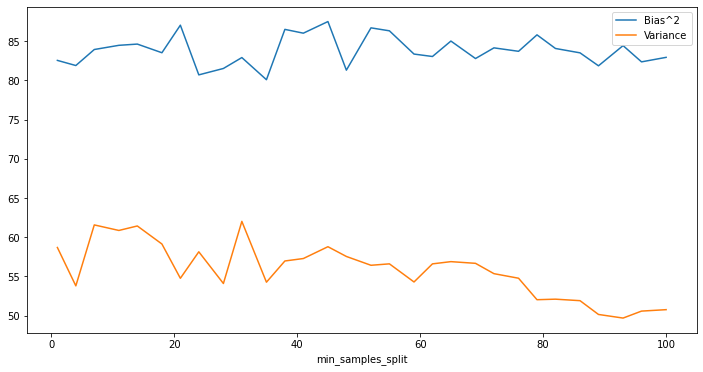

In [17]:
min_samples_splits = np.linspace(1, 100, 30, dtype=int)

biases = []
variances = []

for min_samples_split in min_samples_splits:
    model = MyDecisionTreeRegressor(min_samples_split=min_samples_split)
    bias2, variance = get_bias_variance(model, np.array(X_train), np.array(y_train), 20)
    biases.append(bias2)
    variances.append(variance)
    
plt.figure(figsize=(12, 6))

plt.xlabel("min_samples_split")
plt.plot(min_samples_splits, biases, label='Bias^2')
plt.plot(min_samples_splits, variances, label='Variance')
plt.legend()
plt.show()

При увеличении минимального количества семплов, нужных для сплита, падает Variance, т.к. модель упрощается.
В теории, bias должен расти, т.к. модель упрощается, но на графике нет видимого увеличения.

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [22]:
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor(base_estimator=MyDecisionTreeRegressor(max_depth=7, min_samples_leaf=1), n_estimators=5,
                                   random_state=42)
bias_bagging, variance_bagging = get_bias_variance(model, X_train, y_train, n_iter=20)

model = MyDecisionTreeRegressor(max_depth=7, min_samples_leaf=1)

bias_tree, variance_tree = get_bias_variance(model, X_train, y_train, n_iter=20)

print("Bias^2: tree=", bias_tree, ", bagging=", bias_bagging)
print("Variance: tree=", variance_tree, ", bagging=", variance_bagging)

Bias^2: tree= 83.76359750333235 , bagging= 87.39348937836459
Variance: tree= 79.1373011794433 , bagging= 68.24130994118835


Как и в теории предполгалось, Variance упала на беггинге.
Bias примерно остался таким же, но немного вырос, потому что bagging прощает модель.

# Part 2. More Ensembles

In this part we will be working with [Thyroid Disease Data Set](https://archive.ics.uci.edu/ml/datasets/thyroid+disease) to solve a classification task. 

In [75]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('thyroid_disease.csv')

le = LabelEncoder()
y = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
X.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,...,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,...,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other
2,46.0,M,f,f,f,f,f,f,f,f,...,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other
3,70.0,F,t,f,f,f,f,f,f,f,...,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other
4,70.0,F,f,f,f,f,f,f,f,f,...,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset. 

In [76]:
df.count() / df.shape[0] # Доля заполненных данных по колонкам

age                          0.999735
sex                          0.960233
on_thyroxine                 1.000000
query_on_thyroxine           1.000000
on_antithyroid_medication    1.000000
sick                         1.000000
pregnant                     1.000000
thyroid_surgery              1.000000
I131_treatment               1.000000
query_hypothyroid            1.000000
query_hyperthyroid           1.000000
lithium                      1.000000
goitre                       1.000000
tumor                        1.000000
hypopituitary                1.000000
psych                        1.000000
TSH_measured                 1.000000
TSH                          0.902174
T3_measured                  1.000000
T3                           0.796129
TT4_measured                 1.000000
TT4                          0.938759
T4U_measured                 1.000000
T4U                          0.897402
FTI_measured                 1.000000
FTI                          0.897932
TBG_measured

Удалим колонку TBG, в ней все - пропуски

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) # Делим датасет на трейн и тест

In [78]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


categorical_columns = X.select_dtypes(include='object').columns
numeric_columns = X.select_dtypes(include=np.number).columns

column_transformer = ColumnTransformer([
    ('drop columns', 'drop', 'TBG'),
    ('transform categorical columns', make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder()), categorical_columns),
    ('transform numeric columns', SimpleImputer(strategy='mean'), numeric_columns),
], remainder='passthrough')

# Transform the data
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [88]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

models = [
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    SVC(kernel='linear'),
    LogisticRegression(max_iter=5000)
]

scores = [cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean() for model in models]

for i in range(len(models)):
    print(models[i], 'f1 score =', scores[i], '(bias^2, variance) = ', get_bias_variance(models[i], X_train, y_train, 20))

GradientBoostingClassifier() f1 score = 0.8787663705381249 (bias^2, variance) =  (0.05907430687972046, 0.055423459258461094)
RandomForestClassifier() f1 score = 0.8462823684948356 (bias^2, variance) =  (0.060379068599531814, 0.05191146922846242)
DecisionTreeClassifier() f1 score = 0.8978731897850085 (bias^2, variance) =  (0.059538427156392945, 0.05871385906856293)
SVC(kernel='linear') f1 score = 0.6892979735318445 (bias^2, variance) =  (0.061372121434518666, 0.04875366902992876)
LogisticRegression(max_iter=5000) f1 score = 0.6806525974768616 (bias^2, variance) =  (0.058958133944966, 0.0407341332218524)


Выбираем метрику f1, полагающуюся на precision и recall.
Лучше всего по метрике f1 справилось дерево решений.
SVM и Логистическая регрессия справились хуже всего, т.к. недообучились(это видно по маленькому Variance)
Остальные модели также справились неплохо.

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to implement one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 

To get method that you have to implement, run cell below and input your name in Russian (for example, if you input Андрей, you will see that user with this name should implement xgboost)

In [35]:
def assign_method():
    name = input()
    methods = ['xgboost', 'lightgbm', 'catboost']
    idx = sum([ord(x) for x in list(name)]) % 3
    print('Реализуйте', methods[idx])
    
assign_method()

Луиза
Реализуйте xgboost


In [15]:
# YOUR CODE HERE

```your comments here```

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [193]:
# YOUR CODE HERE

```your comments here```

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train. 

In [ ]:
# YOUR CODE HERE